To apply hierarchical clustering and k-means clustering to a tabular dataset with categorical variables, the following steps can be taken:

1. Load the data into a pandas dataframe.
2. Preprocess the data by converting the categorical variables into one-hot encoded vectors using the `pd.get_dummies()` function.
3. Apply the clustering algorithm of choice, such as hierarchical clustering or k-means clustering, to the preprocessed data.
4. Analyze the resulting clusters, such as by visualizing them using t-SNE or by examining the characteristics of the data points in each cluster.
5. (Optional) Use the resulting clusters to make predictions or to guide further analysis of the data.

It's important to note that the choice of clustering algorithm and the preprocessing steps may vary depending on the specific dataset and research question at hand. It's also important to carefully choose the number of clusters in order to avoid overfitting or underfitting the data. Various methods, such as the elbow method or silhouette analysis, can be used to determine an appropriate number of clusters.


In [1]:
# conda env create -f environment.yml -n torch
# conda activate torch

In [2]:
import pandas as pd
import numpy as np

data_path = 'data/2223RX19_Project_Data.xlsx'

# Load the xlsx file
df = pd.read_excel(data_path)

# split the categories into separate strings
categories = df['CATEGORY']


In [3]:
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
import torch 

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased").to(device)

# Define a dataset class
class CategoryDataset(Dataset):
    def __init__(self, categories, tokenizer):
        self.categories = categories
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.categories)

    def __getitem__(self, idx):
        return self.categories[idx]

# Create a dataset object
dataset = CategoryDataset(categories, tokenizer)

# Create a DataLoader object to create batches of data
batch_size = 8
dataloader = DataLoader(dataset, batch_size=batch_size)


# Create a matrix of embeddings for each category
embeddings_matrix = np.zeros((len(categories), 768))
for i, batch in tqdm(enumerate(dataloader), total=len(dataset)//batch_size):
    with torch.no_grad():
        # tokenize the batch of categories
        tokens = tokenizer(batch, padding=True, truncation=True, return_tensors="pt").to(device)
        # generate the embeddings
        outputs = model(**tokens).last_hidden_state.mean(dim=1)
        # convert the embeddings to numpy
        embeddings = outputs.cpu().numpy()
        # add the embeddings to the dataframe
        embeddings_matrix[i*batch_size:(i+1)*batch_size] = embeddings



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
1247it [01:02, 19.82it/s]                          


In [10]:
from sklearn.cluster import KMeans

# Set the number of clusters
num_clusters = 4

# Create a KMeans object
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit the KMeans object to the embeddings_matrix
kmeans.fit(embeddings_matrix)

# Get the cluster labels for each row of embeddings_matrix
df['cluster_label'] = kmeans.labels_

df.to_excel('export/2223RX19_Project_Data_With_Bert_Cluster_Label.xlsx')


/Users/raphaelattias/opt/miniconda3/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [11]:
grouped = df.groupby('cluster_label')
for label, group in grouped:
    print(f'Cluster {label}: {list(group["COMPANY_ID"])}')

Cluster 0: ['drift', 'upgrad', 'outreach', 'mindtickle', 'discord', 'casper', 'visual-supply-co-vsco', 'snyk', 'weaveworks', 'barkbox', 'classpass', 'controlup-inc', 'lemonade', 'duolingo', 'weee', 'execonline', 'true-balance', 'crehana', 'tile', 'exotel', 'contentful', 'olist', 'carousell', 'ripcord-2', 'animoca-brands-corporation', 'latch', 'hipcamp', 'rever-2', 'lyte', 'roposo', 'heal', 'ginger-io', 'copper-inc', 'back-market', 'bigo-technology', 'parsable', 'ritual-3', 'zilingo', 'doctor-on-demand', 'calm-com', 'mx-player', 'hinge', 'mason', 'greenhouse-software', 'outdoorsy-co', 'patientpop', 'nexar-2', 'button', 'videoamp', 'rigup', 'envested', 'wag', 'tvision-insights', 'konga-online-shopping-limited', 'clever', 'improbable', 'newsela', 'payclip', 'picsart', 'wevideo', 'guardicore', 'tipranks', 'trello', 'onedrop', 'zola', 'spinny', 'soldsie-inc', 'localeur', 'honeybook', 'good-eggs', 'honk-2', 'even-responsible-finance', 'ibotta', 'moneytap-2', 'seldon', 'enjoy', 'shuttl', 'ati

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9971 samples in 0.002s...
[t-SNE] Computed neighbors for 9971 samples in 0.987s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9971
[t-SNE] Computed conditional probabilities for sample 2000 / 9971
[t-SNE] Computed conditional probabilities for sample 3000 / 9971
[t-SNE] Computed conditional probabilities for sample 4000 / 9971
[t-SNE] Computed conditional probabilities for sample 5000 / 9971
[t-SNE] Computed conditional probabilities for sample 6000 / 9971
[t-SNE] Computed conditional probabilities for sample 7000 / 9971
[t-SNE] Computed conditional probabilities for sample 8000 / 9971
[t-SNE] Computed conditional probabilities for sample 9000 / 9971
[t-SNE] Computed conditional probabilities for sample 9971 / 9971
[t-SNE] Mean sigma: 1.593490
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.606094
[t-SNE] KL divergence after 300 iterations: 3.173257


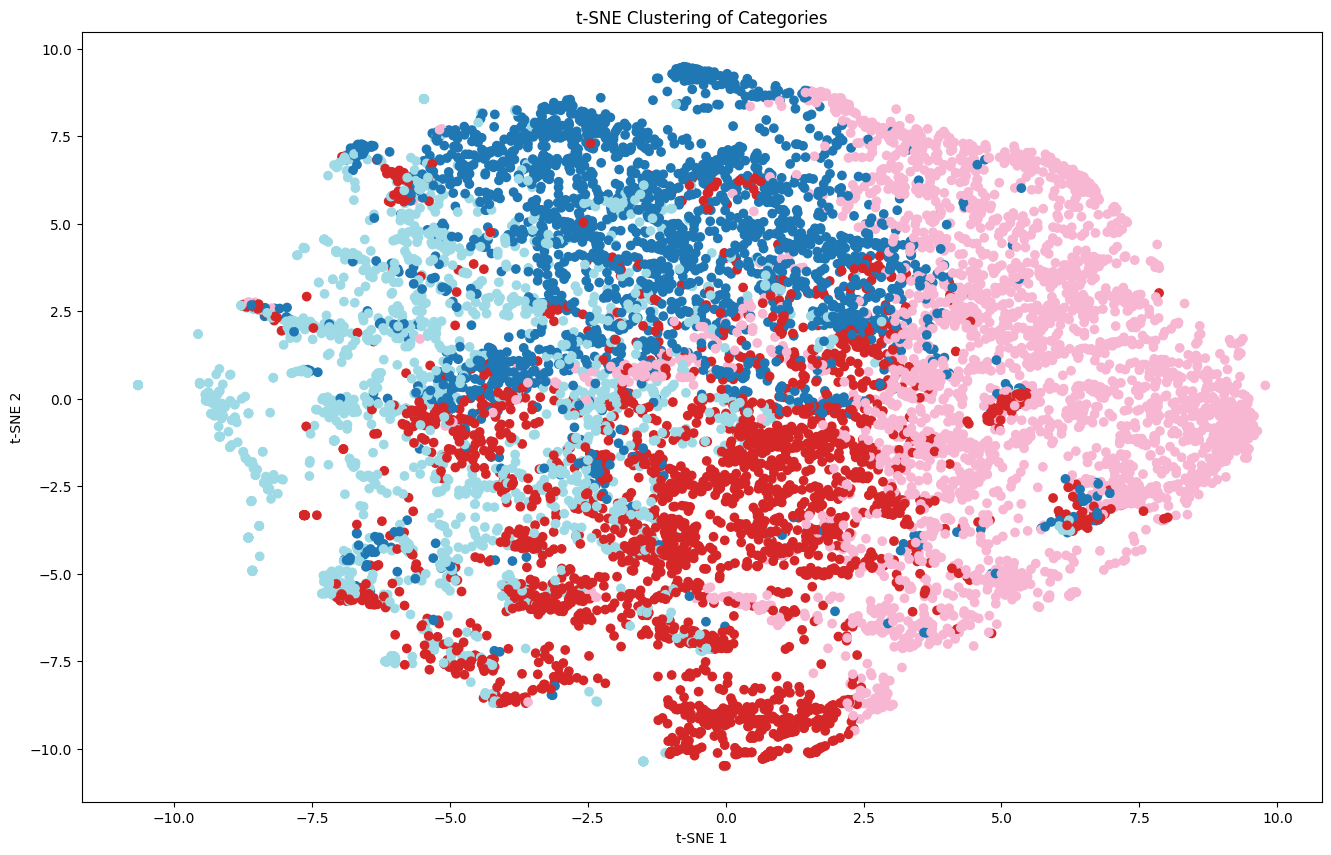

In [12]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# apply t-SNE to reduce the dimensionality of the one-hot encoded categories
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embeddings_matrix)

# create a new dataframe with the t-SNE results
tsne_df = pd.DataFrame(data=tsne_results, columns=['tsne_1', 'tsne_2'])

# plot the t-SNE results and color the points by the cluster labels
plt.figure(figsize=(16,10))
plt.scatter(tsne_df['tsne_1'], tsne_df['tsne_2'], c=df['cluster_label'], cmap='tab20')
plt.title('t-SNE Clustering of Categories')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()